In [1]:
import numpy as np
import pandas as pd
import re
import timeit
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [2]:
import matplotlib.pyplot as plt
def line_plot(title, x_label, y_label, X, Y):
    plt.figure()
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid()
    plt.plot(X, Y)
    plt.show()
    
def line_plot_2(title, x_label, y_label, X1, Y1, X2, Y2, line1, line2, color1='orange', color2='steelblue'):
    plt.figure()
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid()
    plt.plot(X1, Y1, label=line1, color=color1)
    plt.plot(X2, Y2, label=line2, color=color2)
    plt.legend()
    plt.show()

def bar_plot(title, X, Y, X_label, Y_label, ylim=None):
    plt.figure()
    plt.title(title)
    plt.xlabel(X_label)
    plt.ylabel(Y_label)
    plt.ylim(ylim)
    plt.bar(X, Y)
    plt.show()

In [3]:
def clf_run(clf_dict, x_train, y_train, x_test, y_test):
    train_scores = {}
    test_scores = {}
    cv_test_scores = {}
    cv_train_scores = {}
    learning_times = {}
    querying_times = {}
    run_times = {}
    best_estimator_info = {}
    best_estimator_info['best_estimator'] = None
    best_estimator_info['test_score'] = 0
    
    for clf in list(clf_dict.keys()):
        
        current_clf = clf_dict[clf]
        
        t_start = timeit.default_timer()
        current_clf.fit(x_train, y_train)
        t_end = timeit.default_timer()
        t_learning = t_end - t_start
        
        t_start = timeit.default_timer()
        predictions = current_clf.predict(x_test)
        t_end = timeit.default_timer()
        t_querying = t_end - t_start
        
        train_scores[clf] = current_clf.score(x_train, y_train)
        test_scores[clf] = current_clf.score(x_test, y_test)
        cv_test_scores[clf] = cross_val_score(current_clf, x_test, y_test, cv=3).mean()
        cv_train_scores[clf] = cross_val_score(current_clf, x_train, y_train, cv=3).mean()
        learning_times[clf] = t_learning
        querying_times[clf] = t_querying
        run_times[clf] = t_learning + t_querying
        
        if test_scores[clf] >= best_estimator_info['test_score']:
            best_estimator_info['best_estimator'] = current_clf
            best_estimator_info['test_score'] = test_scores[clf]
            best_estimator_info['cv_score'] = cv_test_scores[clf]
            best_estimator_info['learning_time'] = learning_times[clf]
            best_estimator_info['querying_time'] = querying_times[clf]
            best_estimator_info['run_time'] = run_times[clf]
            
    
    return train_scores, test_scores, cv_train_scores, cv_test_scores, learning_times, querying_times, best_estimator_info


In [4]:
def encode_categories(df, col):
    ord_enc = OrdinalEncoder()
    df[col] = ord_enc.fit_transform(df[[col]])

In [5]:
def get_best(gscv, x_test, y_test):
    best_estimator_info = {}
    
    best_estimator_info['best_estimator'] = gscv.best_estimator_
    
    index = gscv.best_index_        
    
    t_start = timeit.default_timer()
    score = gscv.score(x_test, y_test)
    t_end = timeit.default_timer()
    t = t_end - t_start
    
    best_estimator_info['test_score'] = score
    best_estimator_info['cv_score'] = score
    best_estimator_info['learning_time'] = gscv.cv_results_['mean_fit_time'][index]
    best_estimator_info['querying_time'] = t
    best_estimator_info['learning_time'] = best_estimator_info['learning_time'] + best_estimator_info['querying_time']
    
    return best_estimator_info

In [6]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    
    train_sizes, train_scores, test_scores, fit_times, _ = \
    learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="b")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Test score")
    plt.legend()
    plt.show()
    
    # Plot n_samples vs fit_times
    plt.figure()
    plt.title(title+"\nScalability of the model")
    plt.xlabel("Training examples")
    plt.ylabel("fit_times")
    plt.grid()
    plt.fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1,
                         color="b")
    plt.plot(train_sizes, fit_times_mean, 'o-', color="b", label="fit_times")
    plt.legend()
    plt.show()
    
    # Plot fit_times vs score
    #plt.figure()
    #plt.title("Performance of the model")
    #plt.xlabel("fit_times")
    #plt.ylabel("score")
    #plt.grid()
    #plt.fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         #test_scores_mean + test_scores_std, alpha=0.1, color='b')
    #plt.plot(fit_times_mean, test_scores_mean, 'o-', color="b", label="fit_times")
    #plt.legend()
    #plt.show()

In [7]:
# Data Processing
student_data = pd.read_csv("StudentPerformancePor.csv", sep=';')
# display(student_data.head())
    
student_data['total_score'] = student_data.iloc[:, -3:-1].sum(axis=1)
student_data.loc[student_data['total_score'] > student_data['total_score'].mean(), 'performance'] = 1
student_data.loc[student_data['total_score'] <= student_data['total_score'].mean(), 'performance'] = 0
    
student_features = student_data.iloc[:,:30]
student_features = student_features.drop(columns=['school', 'Mjob', 'Fjob', 'nursery', 'absences', \
                                                      'failures', 'reason', 'romantic'])
student_performance = student_data.iloc[:,-1]
    
col_list = ['address','sex','famsize','Pstatus','guardian','schoolsup',\
            'famsup','paid','activities','higher','internet']
for i in col_list:
    encode_categories(student_features, i)
    
# display(student_features.head())
    
# Split Data for training and testing
x_train, x_test, y_train, y_test = train_test_split(student_features, student_performance, \
                                                        test_size=0.2, random_state=2)

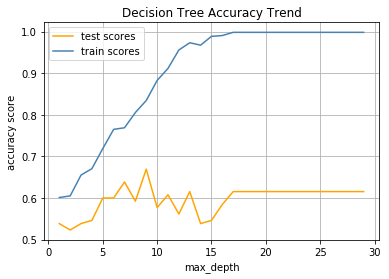

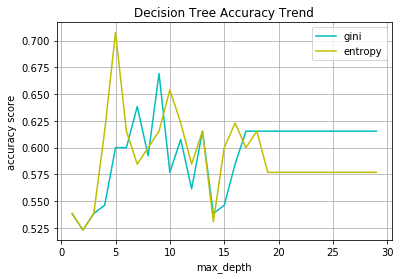

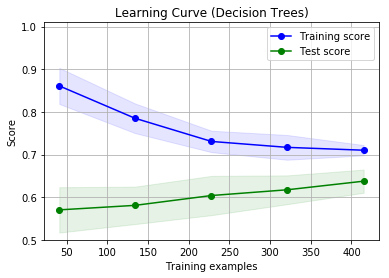

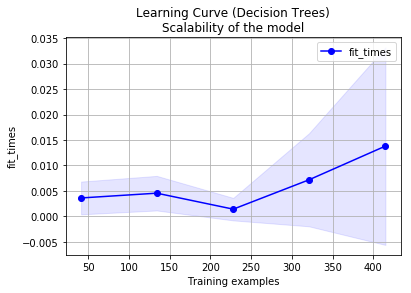

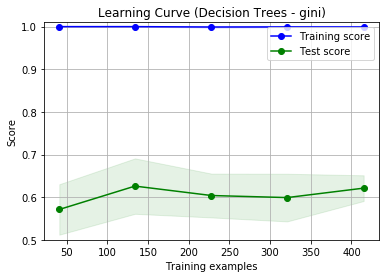

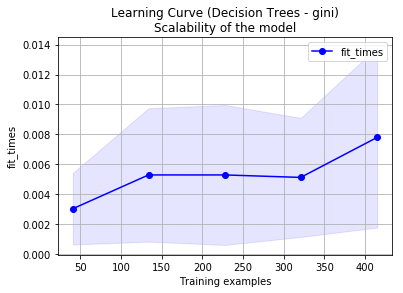

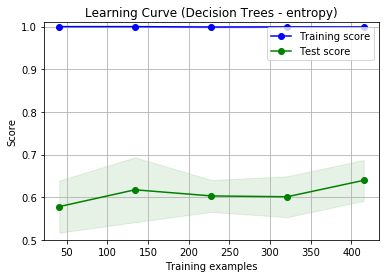

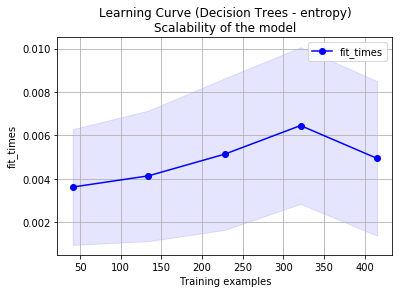

In [13]:
# ==================================== Decision Tree =====================================

dict_DT = {}
DT_param_list = []
for i in range (1,30,1):
    dict_DT[i] = DecisionTreeClassifier(max_depth = i, max_features = 'sqrt', random_state = 2, criterion = 'gini')
    DT_param_list.append(i)
    
# train and test
DT_clf_train_scores, DT_clf_test_scores, DT_clf_cv_train_scores, DT_clf_cv_test_scores, DT_clf_fit_times, \
DT_clf_score_times, DT_best_estimator = clf_run(dict_DT, x_train, y_train, x_test, y_test)

# print
# print("\nDecision Tree ",  "\nTest Scores ", DT_clf_test_scores, "\nTrain Scores", DT_clf_train_scores,\
      #"\nCross Validation Scores ", DT_clf_cv_test_scores, "\nBest Estimator ", DT_best_estimator) 
    
# plot train scores and test scores
DT_test_scores_list = []
DT_train_scores_list = []
for i in DT_param_list:
     DT_test_scores_list.append(DT_clf_test_scores[i])
     DT_train_scores_list.append(DT_clf_train_scores[i])
line_plot_2(title='Decision Tree Accuracy Trend', x_label='max_depth', y_label='accuracy score',\
          X1=DT_param_list, Y1=DT_test_scores_list, X2=DT_param_list, Y2=DT_train_scores_list,\
           line1='test scores', line2='train scores')

# ---------- Tuning criterion Gini vs Entropy -----------
dict_DT2 = {}
for i in range (1,30,1):
    dict_DT2[i] = DecisionTreeClassifier(max_depth = i, max_features = 'sqrt', random_state = 2, criterion = 'entropy')
    
# train and test
DT_clf2_train_scores, DT_clf2_test_scores, DT_clf2_cv_train_scores, DT_clf2_cv_test_scores, DT_clf2_fit_times, \
DT_clfs_score_times, DT_best_estimator2 = clf_run(dict_DT2, x_train, y_train, x_test, y_test)

# print
# print("\nDecision Tree ",  "\nTest Scores ", DT_clf2_test_scores, "\nTrain Scores", DT_clf2_train_scores,\
      #"\nCross Validation Scores ", DT_clf2_cv_test_scores, "\nBest Estimator ", DT_best_estimator2) 

# plot gini scores and entropy scores
DT_test_scores_list2 = []
for i in DT_param_list:
     DT_test_scores_list2.append(DT_clf2_test_scores[i])
line_plot_2(title='Decision Tree Accuracy Trend', x_label='max_depth', y_label='accuracy score',\
          X1=DT_param_list, Y1=DT_test_scores_list, X2=DT_param_list, Y2=DT_test_scores_list2,\
           line1='gini', line2='entropy', color1='c', color2='y')

# plot gini fit times and entropy fit times
#DT_G_fit_time_list = []
#DT_E_fit_time_list = []
#for i in DT_param_list:
     #DT_G_fit_time_list.append(DT_clf_fit_times[i])
     #DT_E_fit_time_list.append(DT_clf2_fit_times[i])
#line_plot_2(title='Decision Tree Fit Times', x_label='max_depth', y_label='fit_time',\
          #X1=DT_param_list, Y1=DT_G_fit_time_list, X2=DT_param_list, Y2=DT_E_fit_time_list,\
           #line1='gini', line2='entropy', color1='c', color2='y')

# find best
if DT_best_estimator2['test_score'] > DT_best_estimator['test_score']:
    DT_best_estimator = DT_best_estimator2
    
# plot learning curve
title = 'Learning Curve (Decision Trees)'
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=2)
estimator = DT_best_estimator['best_estimator']
plot_learning_curve(estimator, title, x_train, y_train, cv=cv, n_jobs=4, ylim=(0.5, 1.01))
title1 = 'Learning Curve (Decision Trees - gini)'
estimator1 = DecisionTreeClassifier(criterion='gini', random_state=2)
plot_learning_curve(estimator1, title1, x_train, y_train, cv=cv, n_jobs=4, ylim=(0.5, 1.01))
title2 = 'Learning Curve (Decision Trees - entropy)'
estimator2 = DecisionTreeClassifier(criterion='entropy', random_state=2)
plot_learning_curve(estimator2, title2, x_train, y_train, cv=cv, n_jobs=4, ylim=(0.5, 1.01))

C:\Users\piano\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\piano\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\piano\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\piano\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

C:\Users\piano\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\piano\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\piano\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\piano\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

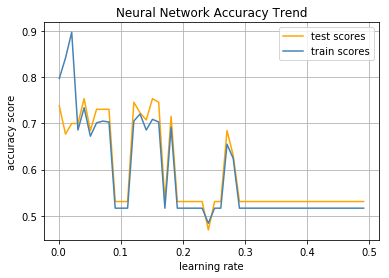

In [9]:
# ======================  Neural Network 1  =========================
dict_NN = {}
NN_param_list = []
for i in np.arange(0.001,0.5,0.01):
    dict_NN[i] = MLPClassifier(learning_rate_init = i.item(), random_state = 2)
    NN_param_list.append(i)
    
# train and test
NN_clf_train_scores, NN_clf_test_scores, NN_clf_cv_train_scores, NN_clf_cv_test_scores, NN_clf_fit_times, \
NN_clf_score_times, NN_best_estimator = \
clf_run(dict_NN, x_train, y_train, x_test, y_test)

# print
# print("\nNeural Network ",  "\nTest Scores ", NN_clf_test_scores, "\nTrain Scores", NN_clf_train_scores,\
      #"\nCross Validation Scores ", NN_clf_cv_test_scores, "\nBest Estimator ", NN_best_estimator) 
    
# plot train scores and test scores
NN_test_scores_list = []
NN_train_scores_list = []
for i in NN_param_list:
     NN_test_scores_list.append(NN_clf_test_scores[i])
     NN_train_scores_list.append(NN_clf_train_scores[i])
line_plot_2(title='Neural Network Accuracy Trend', x_label='learning rate', y_label='accuracy score',\
          X1=NN_param_list, Y1=NN_test_scores_list, X2=NN_param_list, Y2=NN_train_scores_list,\
           line1='test scores', line2='train scores')

C:\Users\piano\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\piano\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\piano\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\piano\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, 

C:\Users\piano\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\piano\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\piano\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\piano\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, 

C:\Users\piano\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\piano\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\piano\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\piano\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, 

C:\Users\piano\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\piano\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\piano\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\piano\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, 

C:\Users\piano\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\piano\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\piano\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\piano\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, 

C:\Users\piano\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\piano\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\piano\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\piano\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, 

C:\Users\piano\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\piano\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\piano\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


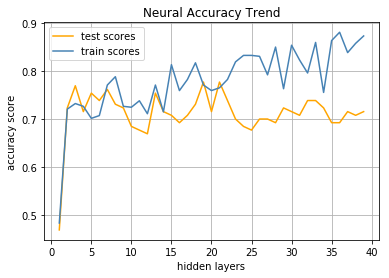

In [10]:
# ======================  Neural Network 2  =========================
dict_NN = {}
NN_param_list = []
for i in range(1,40):
    dict_NN[i] = MLPClassifier(hidden_layer_sizes=(i,),learning_rate_init=0.001, max_iter = 1000, random_state = 2)
    NN_param_list.append(i)
    
# train and test
NN_clf_train_scores, NN_clf_test_scores, NN_clf_cv_train_scores, NN_clf_cv_test_scores, NN_clf_fit_times, \
NN_clf_score_times, NN_best_estimator = \
clf_run(dict_NN, x_train, y_train, x_test, y_test)

# print
# print("\nNeural Network ",  "\nTest Scores ", NN_clf_test_scores, "\nTrain Scores", NN_clf_train_scores,\
      #"\nCross Validation Scores ", NN_clf_cv_test_scores, "\nBest Estimator ", NN_best_estimator) 
    
# plot train scores and test scores
NN_test_scores_list = []
NN_train_scores_list = []
for i in NN_param_list:
     NN_test_scores_list.append(NN_clf_test_scores[i])
     NN_train_scores_list.append(NN_clf_train_scores[i])
line_plot_2(title='Neural Accuracy Trend', x_label='hidden layers', y_label='accuracy score',\
          X1=NN_param_list, Y1=NN_test_scores_list, X2=NN_param_list, Y2=NN_train_scores_list,\
           line1='test scores', line2='train scores')

C:\Users\piano\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\piano\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\piano\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\piano\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

C:\Users\piano\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\piano\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\piano\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\piano\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

C:\Users\piano\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\piano\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\piano\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\piano\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

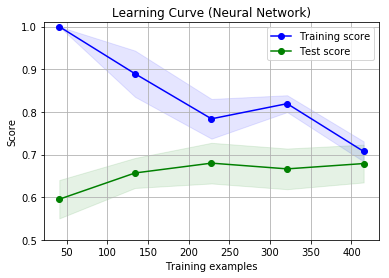

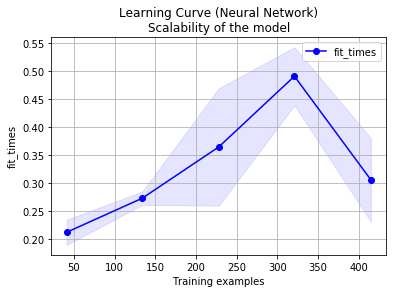

In [11]:
# find best (Grid Search)
NN_parameters = {'hidden_layer_sizes': [(1,),(5,),(11,),(12,),(15,),(16,),(17,),(25,),(30,),(37,)], \
                 'learning_rate_init': [0.001, 0.003,0.005,0.007,0.008]}
gscv_NN = GridSearchCV(MLPClassifier(random_state=2), param_grid = NN_parameters, return_train_score = True)
gscv_NN.fit(x_train, y_train)
NN_best_estimator = get_best(gscv_NN, x_test, y_test)

# plot learning curve
title = 'Learning Curve (Neural Network)'
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=2)
estimator = NN_best_estimator['best_estimator']
plot_learning_curve(estimator, title, x_train, y_train, cv=cv, n_jobs=4, ylim=(0.5, 1.01))

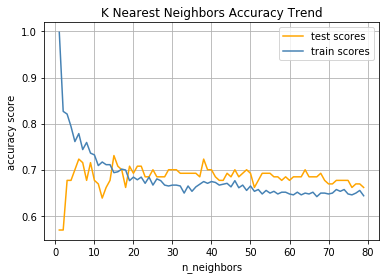

In [15]:
# ======================  K Nearest Neighbors  =========================
dict_KNN = {}
KNN_param_list = []
for i in range(1,80):
    dict_KNN[i] = KNeighborsClassifier(n_neighbors = i)
    KNN_param_list.append(i)
    
# train and test
KNN_clf_train_scores, KNN_clf_test_scores, KNN_clf_cv_train_scores, KNN_clf_cv_test_scores, KNN_clf_fit_times, \
KNN_clf_score_times,KNN_best_estimator = \
clf_run(dict_KNN, x_train, y_train, x_test, y_test)

# print
#print("\nK Nearest Neigbhor ",  "\nTest Scores ", KNN_clf_test_scores, "\nTrain Scores", KNN_clf_train_scores,\
      #"\nCross Validation Scores ", KNN_clf_cv_test_scores, "\nBest Estimator ", KNN_best_estimator) 
    
# plot train scores and test scores
KNN_test_scores_list = []
KNN_train_scores_list = []
for i in KNN_param_list:
     KNN_test_scores_list.append(KNN_clf_test_scores[i])
     KNN_train_scores_list.append(KNN_clf_train_scores[i])
line_plot_2(title='K Nearest Neighbors Accuracy Trend', x_label='n_neighbors', y_label='accuracy score',\
          X1=KNN_param_list, Y1=KNN_test_scores_list, X2=KNN_param_list, Y2=KNN_train_scores_list,\
           line1='test scores', line2='train scores')


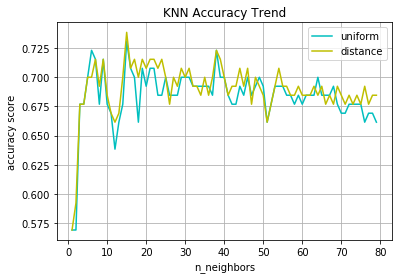

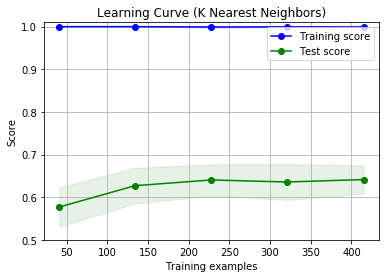

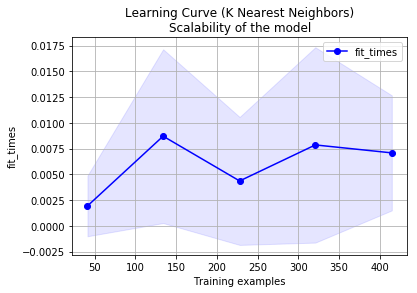

In [16]:
# ---------- Tuning Weights uniform vs disance -----------
dict_KNN2 = {}
for i in range (1,80):
    dict_KNN2[i] = KNeighborsClassifier(n_neighbors = i, weights = 'distance')
    
# train and test
KNN_clf2_train_scores, KNN_clf2_test_scores, KNN_clf2_cv_train_scores, KNN_clf2_cv_test_scores, KNN_clf2_fit_times, \
KNN_clf2_score_times, KNN_best_estimator2 = \
clf_run(dict_KNN2, x_train, y_train, x_test, y_test)

# print
# print("\nNeural Network ",  "\nTest Scores ", KNN_clf2_test_scores, "\nTrain Scores", KNN_clf2_train_scores,\
      #"\nCross Validation Scores ", KNN_clf2_cv_test_scores, "\nBest Estimator ", KNN_best_estimator2) 

# plot gini scores and entropy scores
KNN_test_scores_list2 = []
for i in KNN_param_list:
     KNN_test_scores_list2.append(KNN_clf2_test_scores[i])
line_plot_2(title='KNN Accuracy Trend', x_label='n_neighbors', y_label='accuracy score',\
          X1=KNN_param_list, Y1=KNN_test_scores_list, X2=KNN_param_list, Y2=KNN_test_scores_list2,\
           line1='uniform', line2='distance', color1='c', color2='y')

# find best
if KNN_best_estimator2['test_score'] > KNN_best_estimator['test_score']:
    KNN_best_estimator = KNN_best_estimator2

# plot learning curve
title = 'Learning Curve (K Nearest Neighbors)'
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=2)
estimator = KNN_best_estimator['best_estimator']
plot_learning_curve(estimator, title, x_train, y_train, cv=cv, n_jobs=4, ylim=(0.5, 1.01))

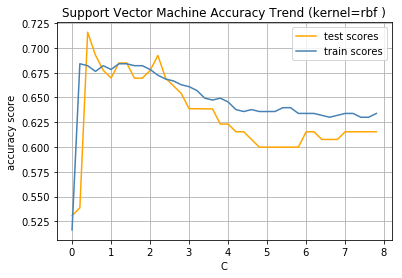

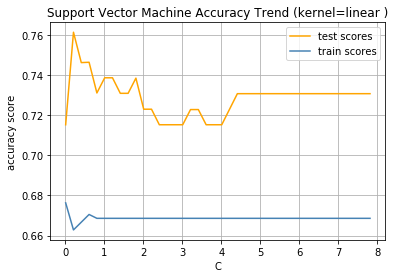

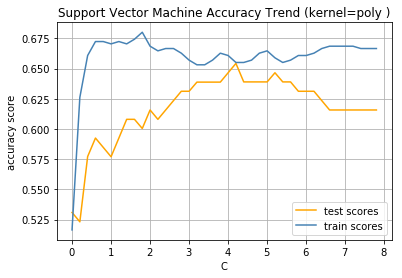

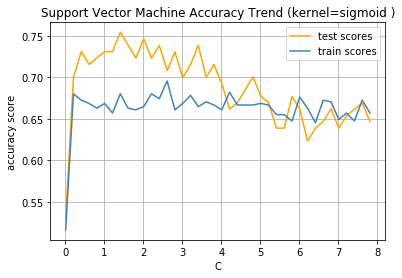

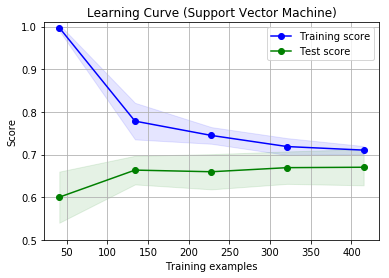

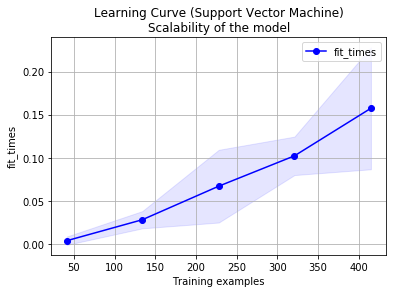

In [17]:
# =======================  Support Vector Machine  =========================

# Preprocessing data: scale x_train and x_test for SVM algorithm and faster grid search
scaled_x_train = StandardScaler().fit_transform(x_train)
scaled_x_test = StandardScaler().fit_transform(x_test)

SVM_best_estimator = {}
SVM_best_estimator['cv_score'] = 0

kernels = ['rbf', 'linear', 'poly', 'sigmoid']
for kernel in kernels:
    dict_SVM = {}
    SVM_param_list = []
    for i in np.arange(0.01, 8, 0.2):
        dict_SVM[i] = SVC(kernel = kernel, C = i.item(), random_state = 2, gamma = 'scale')
        SVM_param_list.append(i)

    # train and test
    SVM_clf_train_scores, SVM_clf_test_scores, SVM_clf_cv_train_scores, SVM_clf_cv_test_scores, SVM_clf_fit_times, \
SVM_clf_score_times, SVM_best_estimator_current \
    = clf_run(dict_SVM, scaled_x_train, y_train, scaled_x_test, y_test)

    # print
    # print("\nSupport Vector Machine ",  "\nTest Scores ", SVM_clf_test_scores, "\nTrain Scores", SVM_clf_train_scores,\
      # "\nCross Validation Scores ", SVM_clf_cv_test_scores, "\nBest Estimator ", SVM_best_estimator) 
    
    # plot train scores and test scores
    SVM_test_scores_list = []
    SVM_train_scores_list = []
    for i in SVM_param_list:
         SVM_test_scores_list.append(SVM_clf_cv_test_scores[i])
         SVM_train_scores_list.append(SVM_clf_cv_train_scores[i])
    line_plot_2(title='Support Vector Machine Accuracy Trend (kernel='+kernel+' )', x_label='C', y_label='accuracy score',\
              X1=SVM_param_list, Y1=SVM_test_scores_list, X2=SVM_param_list, Y2=SVM_train_scores_list,\
               line1='test scores', line2='train scores')
    
    if SVM_best_estimator_current['cv_score'] > SVM_best_estimator['cv_score']:
        SVM_best_estimator = SVM_best_estimator_current

# plot learning curve
title = 'Learning Curve (Support Vector Machine)'
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=2)
estimator = SVM_best_estimator['best_estimator']
plot_learning_curve(estimator, title, scaled_x_train, y_train, cv=cv, n_jobs=4, ylim=(0.5, 1.01))

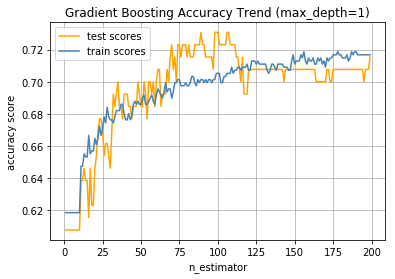

In [18]:
# ==================================== Boostrapping 1 =====================================
dict_GBT = {}
GBT_param_list = []
for i in range (1,200):
    dict_GBT[i] = GradientBoostingClassifier(n_estimators=i, max_depth=1, random_state = 2)
    GBT_param_list.append(i)
    
# train and test
GBT_clf_train_scores, GBT_clf_test_scores, GBT_clf_cv_train_scores, GBT_clf_cv_test_scores, GBT_clf_fit_times, \
GBT_clf_score_times, GBT_best_estimator = \
clf_run(dict_GBT, x_train, y_train, x_test, y_test)

# print
#print("\nGradient Boosting ",  "\nTest Scores ", GBT_clf_test_scores, "\nTrain Scores", GBT_clf_train_scores,\
      #"\nCross Validation Scores ", GBT_clf_cv_test_scores, "\nBest Estimator ", GBT_best_estimator) 
    
# plot train scores and test scores
GBT_test_scores_list = []
GBT_train_scores_list = []
for i in GBT_param_list:
     GBT_test_scores_list.append(GBT_clf_test_scores[i])
     GBT_train_scores_list.append(GBT_clf_train_scores[i])
line_plot_2(title='Gradient Boosting Accuracy Trend (max_depth=1)', x_label='n_estimator', y_label='accuracy score',\
          X1=GBT_param_list, Y1=GBT_test_scores_list, X2=GBT_param_list, Y2=GBT_train_scores_list,\
           line1='test scores', line2='train scores')


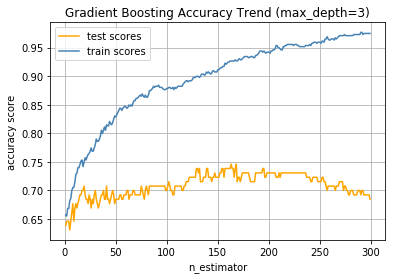

In [19]:
# ==================================== Boostrapping 2 =====================================
dict_GBT = {}
GBT_param_list = []
for i in range (1,300):
    dict_GBT[i] = GradientBoostingClassifier(n_estimators=i, max_depth=3, random_state = 2)
    GBT_param_list.append(i)
    
# train and test
GBT_clf_train_scores, GBT_clf_test_scores, GBT_clf_cv_train_scores, GBT_clf_cv_test_scores, GBT_clf_fit_times, \
GBT_clf_score_times, GBT_best_estimator = \
clf_run(dict_GBT, x_train, y_train, x_test, y_test)

# print
#print("\nGradient Boosting ",  "\nTest Scores ", GBT_clf_test_scores, "\nTrain Scores", GBT_clf_train_scores,\
      #"\nCross Validation Scores ", GBT_clf_cv_test_scores, "\nBest Estimator ", GBT_best_estimator) 
    
# plot train scores and test scores
GBT_test_scores_list = []
GBT_train_scores_list = []
for i in GBT_param_list:
     GBT_test_scores_list.append(GBT_clf_test_scores[i])
     GBT_train_scores_list.append(GBT_clf_train_scores[i])
line_plot_2(title='Gradient Boosting Accuracy Trend (max_depth=3)', x_label='n_estimator', y_label='accuracy score',\
          X1=GBT_param_list, Y1=GBT_test_scores_list, X2=GBT_param_list, Y2=GBT_train_scores_list,\
           line1='test scores', line2='train scores')


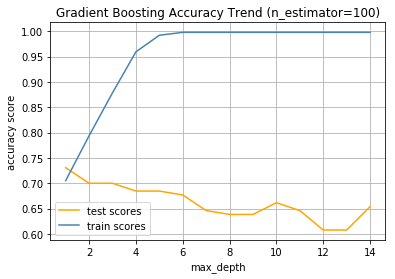

In [20]:
# ==================================== Boostrapping 3 =====================================
dict_GBT = {}
GBT_param_list = []
for i in range (1,15):
    dict_GBT[i] = GradientBoostingClassifier(n_estimators=100, max_depth=i, random_state = 2)
    GBT_param_list.append(i)
    
# train and test
GBT_clf_train_scores, GBT_clf_test_scores, GBT_clf_cv_train_scores, GBT_clf_cv_test_scores, GBT_clf_fit_times, \
GBT_clf_score_times, GBT_best_estimator = \
clf_run(dict_GBT, x_train, y_train, x_test, y_test)

# print
#print("\nGradient Boosting ",  "\nTest Scores ", GBT_clf_test_scores, "\nTrain Scores", GBT_clf_train_scores,\
      #"\nCross Validation Scores ", GBT_clf_cv_test_scores, "\nBest Estimator ", GBT_best_estimator) 
    
# plot train scores and test scores
GBT_test_scores_list = []
GBT_train_scores_list = []
for i in GBT_param_list:
     GBT_test_scores_list.append(GBT_clf_test_scores[i])
     GBT_train_scores_list.append(GBT_clf_train_scores[i])
line_plot_2(title='Gradient Boosting Accuracy Trend (n_estimator=100)', x_label='max_depth', y_label='accuracy score',\
          X1=GBT_param_list, Y1=GBT_test_scores_list, X2=GBT_param_list, Y2=GBT_train_scores_list,\
           line1='test scores', line2='train scores')

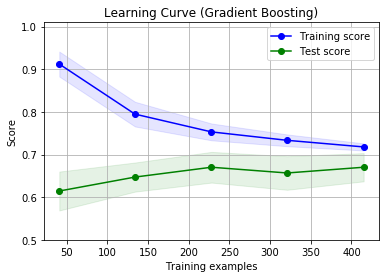

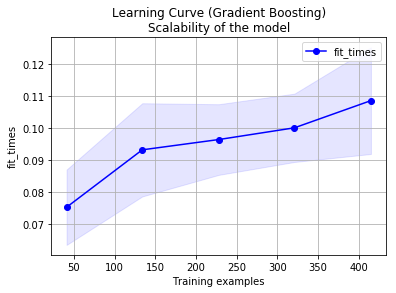

In [29]:
# find best (Grid Search)
GBT_parameters = {'n_estimators': [23, 45, 60, 70, 100, 150], 'max_depth': [1, 3, 5]}
gscv_GBT = GridSearchCV(GradientBoostingClassifier(random_state=2), param_grid = GBT_parameters, return_train_score = True)
gscv_GBT.fit(x_train, y_train)
GBT_gscv_best_estimator = get_best(gscv_GBT, x_test, y_test)

# plot learning curve
title = 'Learning Curve (Gradient Boosting)'
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=2)
estimator = GBT_best_estimator['best_estimator']
plot_learning_curve(estimator, title, x_train, y_train, cv=cv, n_jobs=4, ylim=(0.5, 1.01))

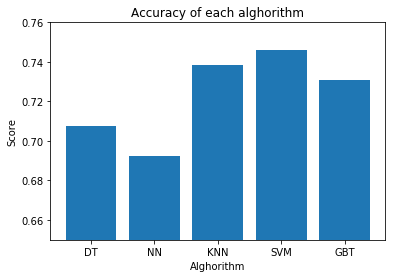

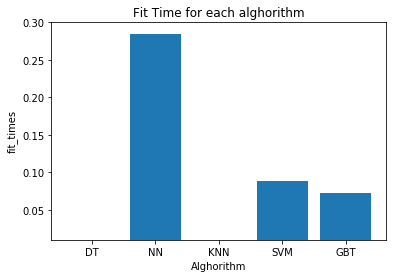

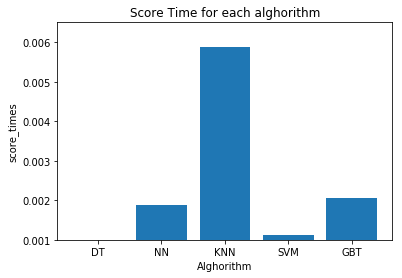

Decision Tree {'best_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2, splitter='best'), 'test_score': 0.7076923076923077, 'cv_score': 0.7003171247357294, 'learning_time': 0.0014155000000073414, 'querying_time': 0.0006322999998928935, 'run_time': 0.002047799999900235} 
 
Neural Network {'best_estimator': MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(37,), learning_rate='constant',
              learning_rate_init=0.005, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=

In [32]:
# ========================= Algorithms Comparison ===========================
algrs = ['DT', 'NN', 'KNN', 'SVM', 'GBT']

scores = [DT_best_estimator['test_score'], NN_best_estimator['test_score'], KNN_best_estimator['test_score'], \
        SVM_best_estimator['test_score'], GBT_best_estimator['test_score']]
bar_plot(title = 'Accuracy of each alghorithm', X_label = 'Alghorithm', Y_label = "Score", \
         X = algrs, Y = scores, ylim=[0.65,0.76])

fit_times = [DT_best_estimator['learning_time'], NN_best_estimator['learning_time'], KNN_best_estimator['learning_time'], \
        SVM_best_estimator['learning_time'], GBT_best_estimator['learning_time']]
bar_plot(title = 'Fit Time for each alghorithm', X_label = 'Alghorithm', Y_label = "fit_times", \
         X = algrs, Y = fit_times, ylim=[0.01,0.3])

score_times = [DT_best_estimator['querying_time'], NN_best_estimator['querying_time'], KNN_best_estimator['querying_time'], \
        SVM_best_estimator['querying_time'], GBT_best_estimator['querying_time']]
bar_plot(title = 'Score Time for each alghorithm', X_label = 'Alghorithm', Y_label = "score_times", \
         X = algrs, Y = score_times, ylim=[0.001,0.0065])

# Print Best Estimators
print('Decision Tree', DT_best_estimator,'\n',\
     '\nNeural Network', NN_best_estimator,'\n',\
      '\nK Nearest Neighbors', KNN_best_estimator,'\n',\
     '\nSupport Vector Machine', SVM_best_estimator,'\n',\
     '\nGradient Boosting', GBT_best_estimator,\
     )